In [1]:
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
ratings = pd.read_pickle("tiny_selection_longform.pkl")

In [4]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()
n_users

2390

In [5]:
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()
n_movies

1648

In [6]:
nmovie_id = ratings.movie_id.nunique()
nuser_id = ratings.user_id.nunique()

In [7]:
X_train, X_test = train_test_split(ratings[['movie', 'user', 'rating_score']], test_size=0.2, random_state=42)

In [8]:
HP_NUM_UNITS = [64]
HP_DROPOUT = [.3, .4, .5]
HP_LEARNING_RATE = [.01]
HP_REGULARIZER = ['l2', None]

In [9]:
def train_test_model(hparams):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    x = keras.layers.Dense(hparams['HP_NUM_UNITS'], 
                           activation='relu', 
                           kernel_regularizer=hparams['HP_REGULARIZER'])(conc_layer)
    dropout = x = keras.layers.Dropout(rate=hparams['HP_DROPOUT'], seed=42)(x)
    x_out = x = keras.layers.Dense(1, 
                                   activation='relu',
                                  kernel_regularizer=hparams['HP_REGULARIZER'])(x)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=hparams['HP_LEARNING_RATE'])
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())
    
    hist = model.fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=10000, epochs=10, validation_split=.2)

#     print(hist.history['val_mean_squared_error'])
    return hist

In [10]:
run_history = {}

session_num = 0

for num_units in HP_NUM_UNITS:
    for dropout_rate in HP_DROPOUT:
        for learning_rate in HP_LEARNING_RATE:
            for regularization in HP_REGULARIZER:
                hparams = {
                'HP_NUM_UNITS': num_units,
                'HP_DROPOUT': dropout_rate,
                'HP_LEARNING_RATE': learning_rate,
                'HP_REGULARIZER': regularization,
                }
                
                run_name = "run-{}".format(session_num)
                print("----Starting trial: {}".format(run_name))
                print(hparams)
                
                output = train_test_model(hparams,)
                run_history[run_name] = {
                    'params': hparams,
                    'output': output,
                }
                session_num += 1

----Starting trial: run-0
{'HP_NUM_UNITS': 64, 'HP_DROPOUT': 0.3, 'HP_LEARNING_RATE': 0.01, 'HP_REGULARIZER': 'l2'}
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 11.1274 - root_mean_squared_error: 3.2692 - val_loss: 10.5195 - val_root_mean_squared_error: 3.1800
Epoch 2/10
1/1 [==============================] - 0s 274ms/step - loss: 10.5452 - root_mean_squared_error: 3.1840 - val_loss: 10.0130 - val_root_mean_squared_error: 3.1029
Epoch 3/10
1/1 [==============================] - 0s 342ms/step - loss: 9.8952 - root_mean_squared_error: 3.0839 - val_loss: 9.4530 - val_root_mean_squared_error: 3.0141
Epoch 4/10
1/1 [==============================] - 0s 323ms/step - loss: 9.1233 - root_mean_squared_error: 2.9589 - val_loss: 8.8331 - val_root_mean_squared_error: 2.9114
Epoch 5/10
1/1 [==============================] - 0s 316ms/step - loss: 8.2276 - root_mean_squared_error: 2.8055 - val_loss: 8.1544 - val_root_mean_squared_error: 2.7937
Epoch 6/10
1/1 [=================

Epoch 6/10
1/1 [==============================] - 0s 154ms/step - loss: 8.2622 - root_mean_squared_error: 2.8232 - val_loss: 8.3471 - val_root_mean_squared_error: 2.8404
Epoch 7/10
1/1 [==============================] - 0s 110ms/step - loss: 7.4037 - root_mean_squared_error: 2.6692 - val_loss: 7.7368 - val_root_mean_squared_error: 2.7325
Epoch 8/10
1/1 [==============================] - 0s 106ms/step - loss: 6.4239 - root_mean_squared_error: 2.4807 - val_loss: 7.0945 - val_root_mean_squared_error: 2.6133
Epoch 9/10
1/1 [==============================] - 0s 112ms/step - loss: 5.3707 - root_mean_squared_error: 2.2595 - val_loss: 6.4339 - val_root_mean_squared_error: 2.4839
Epoch 10/10
1/1 [==============================] - 0s 160ms/step - loss: 4.4050 - root_mean_squared_error: 2.0350 - val_loss: 5.7747 - val_root_mean_squared_error: 2.3470
----Starting trial: run-5
{'HP_NUM_UNITS': 64, 'HP_DROPOUT': 0.5, 'HP_LEARNING_RATE': 0.01, 'HP_REGULARIZER': None}
Epoch 1/10
1/1 [=================

In [12]:
import matplotlib.pyplot as plt

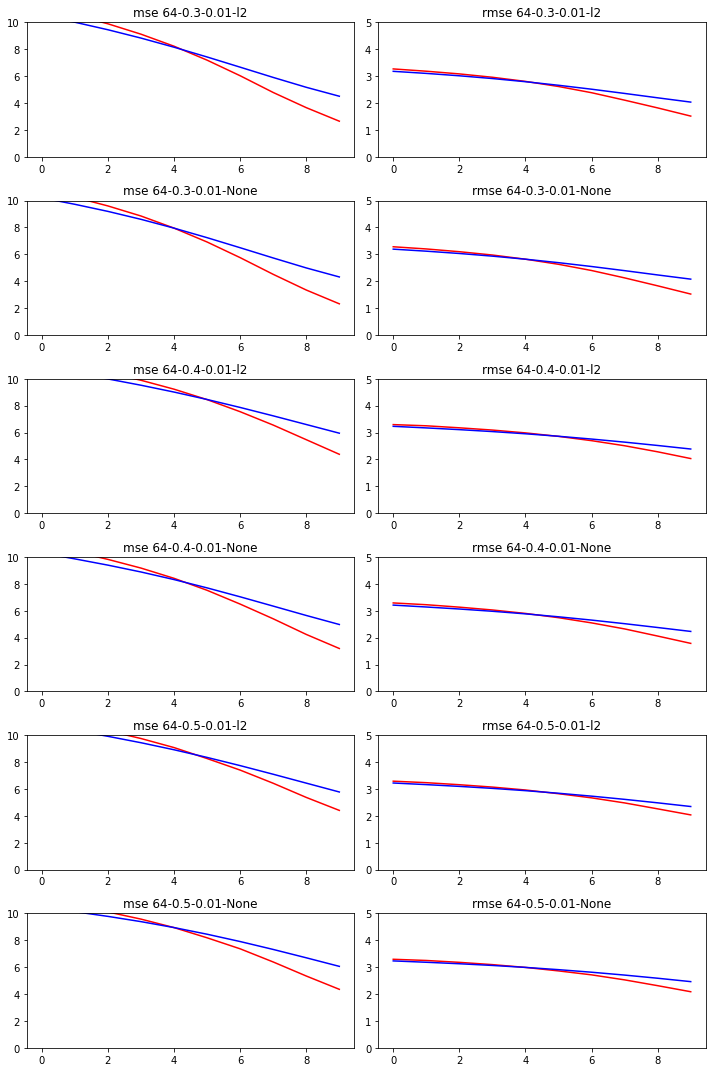

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=len(run_history.keys()), figsize=(10, 15))

for n, key in enumerate(run_history.keys()):
    axs[n,0].plot(run_history[key]['output'].history['loss'], color='r')
    axs[n,0].plot(run_history[key]['output'].history['val_loss'], color='b')
    
    axs[n,1].plot(run_history[key]['output'].history['root_mean_squared_error'], color='r')
    axs[n,1].plot(run_history[key]['output'].history['val_root_mean_squared_error'], color='b')
    
    title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys())
    
    axs[n,0].set_title("mse {}".format(title_str))
    axs[n,1].set_title("rmse {}".format(title_str))
    
    axs[n,0].set_ylim(0,10)
    axs[n,1].set_ylim(0,5)
    
plt.tight_layout()   
plt.show()

In [15]:
import json
def export_history(run_history, batch_size, n_epochs, save_path):
    history_dict = run_history.copy()
    for key in history_dict:
        if history_dict[key]['params']['HP_REGULARIZER']=='l2':
            
            history_dict[key]['params']['HP_REGULARIZER'] = .01
        else:
            try:
                history_dict[key]['params']['HP_REGULARIZER'] = history_dict[key]['params']['HP_REGULARIZER'].l2.tolist()
            except:
                pass   
        if type(history_dict[key]['params']['HP_REGULARIZER']) == np.ndarray:
            history_dict[key]['params']['HP_REGULARIZER'] = history_dict[key]['params']['HP_REGULARIZER'].tolist()
        history_dict[key]['params']['batch_size'] = batch_size
        history_dict[key]['params']['n_epochs'] = n_epochs
        
        try:
            history_dict[key]['output'] = history_dict[key]['output'].history
        except:
            history_dict[key]['output'] = history_dict[key]['output']
      
    with open(save_path, 'w') as f:
        json.dump(history_dict, f)
    
    return history_dict

new_dict = export_history(run_history, 10000, 10, "./run_history/model2.json")

In [16]:
new_dict['run-1']

{'params': {'HP_NUM_UNITS': 64,
  'HP_DROPOUT': 0.3,
  'HP_LEARNING_RATE': 0.01,
  'HP_REGULARIZER': None,
  'batch_size': 10000,
  'n_epochs': 10},
 'output': {'loss': [10.773707389831543,
   10.248364448547363,
   9.602518081665039,
   8.8535737991333,
   7.952383041381836,
   6.919047832489014,
   5.7557854652404785,
   4.513757705688477,
   3.346676826477051,
   2.320180654525757],
  'root_mean_squared_error': [3.2823326587677,
   3.2013065814971924,
   3.0987930297851562,
   2.9754955768585205,
   2.8199970722198486,
   2.63040828704834,
   2.3991217613220215,
   2.124560594558716,
   1.829392433166504,
   1.5232138633728027],
  'val_loss': [10.202666282653809,
   9.723979949951172,
   9.196727752685547,
   8.606270790100098,
   7.9515252113342285,
   7.2416768074035645,
   6.493093490600586,
   5.731584072113037,
   4.990701198577881,
   4.319075107574463],
  'val_root_mean_squared_error': [3.1941611766815186,
   3.1183297634124756,
   3.0326106548309326,
   2.9336445331573486,
 